In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from operator import itemgetter
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso 
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
all_qbs= pd.read_csv('stats/nfl/qbs_for_ai.csv')
all_qbs


,Unnamed: 0,Rk,Player,Year,Age,Draft,Tm,Lg,G,GS,...,4QC,GWD,RUSHAtt,RUSHYds,RUSHY/A,RUSHTD,RUSHY/G,TotYds,TotTD,MVP
0,0,1,Peyton Manning\MannPe00,2013,37,1-1,DEN,NFL,16,16,...,2.0,2.0,32,-31,-0.97,1,-1.9,5446,56,1
1,1,2,Drew Brees\BreeDr00,2011,32,2-32,NOR,NFL,16,16,...,3.0,4.0,21,86,4.10,1,5.4,5562,47,0
2,2,3,Tom Brady\BradTo00,2011,34,6-199,NWE,NFL,16,16,...,1.0,2.0,43,109,2.53,3,6.8,5344,42,0
3,3,4,Drew Brees\BreeDr00,2016,37,2-32,NOR,NFL,16,16,...,2.0,4.0,23,20,0.87,2,1.3,5228,39,0
4,4,5,Drew Brees\BreeDr00,2012,33,2-32,NOR,NFL,16,16,...,1.0,2.0,15,5,0.33,1,0.3,5182,44,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,1996,Steve Beuerlein\BeueSt00,1997,32,4-110,CAR,NFL,7,3,...,1.0,1.0,4,32,8.00,0,4.6,1064,6,0
1996,1996,1997,Turk Schonert\SchoTu00,1986,29,9-242,ATL,NFL,8,5,...,NaN,NaN,11,12,1.09,1,1.5,1044,5,0
1997,1997,1998,Jerry Rhome\RhomJe00,1970,28,13-172 25-195AFL,HOU,NFL,13,4,...,NaN,NaN,9,54,6.00,1,4.2,1085,6,0
1998,1998,1999,Pete Beathard\BeatPe00,1971,29,1-5 1-2AFL,STL,NFL,9,5,...,NaN,NaN,4,29,7.25,0,3.2,1059,6,0


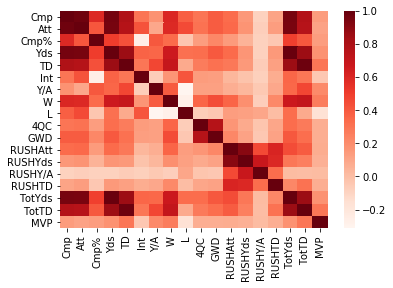

In [4]:
cor = all_qbs[['Cmp','Att','Cmp%','Yds','TD','Int','Y/A','W','L','4QC','GWD','RUSHAtt','RUSHYds','RUSHY/A','RUSHTD','TotYds','TotTD','MVP']].corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.show()

In [5]:
cor_target = abs(cor["MVP"])
relevant_features = cor_target[cor_target>0.15]
relevant_features

Yds       0.181975
TD        0.294600
Y/A       0.212123
W         0.264812
L         0.162691
TotYds    0.184418
TotTD     0.294964
MVP       1.000000
Name: MVP, dtype: float64

In [6]:
# Backward Elimination

basics = ['Cmp','Att','Cmp%','Yds','TD','Int','Y/A','W','L','RUSHAtt','RUSHYds','RUSHY/A','RUSHTD','TotYds','TotTD']



X_1 = sm.add_constant(X[basics])
model = sm.OLS(y,X_1).fit() # ordinary least squares
model.pvalues # probability value

NameError: name 'X' is not defined

In [7]:
# Recursive Feature Elimination

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X[basics], y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
print(basics)

NameError: name 'X' is not defined

In [8]:
# Principal Component Analysis - uses linear algebra to transform the dataset into a compressed form.

pca = PCA(n_components=3)
fit = pca.fit(X[basics])
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

NameError: name 'X' is not defined

In [9]:
# Feature Importance - using a Random Forest and Extra Tree can be used to estimate the importance of features
modelFeatureImportance = ExtraTreesClassifier(n_estimators=10)
modelFeatureImportance.fit(X[basics], y)

for x in range(len(basics)):
    print(modelFeatureImportance.feature_importances_[x],' : ', basics[x])

NameError: name 'X' is not defined

In [10]:
basic_features = ['TotTD','TotYds','W','Yds','TD','Y/A','L']

#Upsampling
mvp = all_qbs[all_qbs.MVP==1]
non = all_qbs[all_qbs.MVP==0]

mvp_unsampled = resample(mvp, replace=True,n_samples=500,random_state=123)

upsampled = pd.concat([non, mvp_unsampled])
upsampled.MVP.value_counts()
y=upsampled.MVP
X=upsampled.drop('MVP', axis=1)

In [11]:
train, test = train_test_split(upsampled, test_size = 0.5, random_state = 36)

xtrain = train[['TotTD','TotYds','W','Yds','TD','Y/A','L']]
ytrain = train[['MVP']]

xtest = test[['TotTD','TotYds','W','Yds','TD','Y/A','L']]
ytest = test[['MVP']]

print("Training set size: %.0f" % len(xtrain))
print("Testing set size: %.0f" % len(xtest))

Training set size: 1228
Testing set size: 1229


In [12]:
def scores(model):

    model.fit(xtrain, ytrain.values.ravel())
    y_pred = model.predict(xtest)
    
    print("Accuracy score: %.3f" % metrics.accuracy_score(ytest, y_pred))
    print("Recall: %.3f" % metrics.recall_score(ytest, y_pred))
    print("Precision: %.3f" % metrics.precision_score(ytest, y_pred))
    print("F1: %.3f" % metrics.f1_score(ytest, y_pred))
    
    proba = model.predict_proba(xtest)
    print("Log loss: %.3f" % metrics.log_loss(ytest, proba))

    pos_prob = proba[:, 1]
    print("Area under ROC curve: %.3f" % metrics.roc_auc_score(ytest, pos_prob))
    
    cv = cross_val_score(model, xtest, ytest.values.ravel(), cv = 3, scoring = 'accuracy')
    print("Accuracy (cross validation score): %0.3f (+/- %0.3f)" % (cv.mean(), cv.std() * 2))
    
    return y_pred

In [13]:
svc = SVC(kernel = 'rbf', gamma = 1e-3, C = 100, probability = True)
print('SVC Scores')
y_svc = scores(svc)

SVC Scores
Accuracy score: 0.979
Recall: 0.972
Precision: 0.928
F1: 0.949
Log loss: 0.087
Area under ROC curve: 0.994
Accuracy (cross validation score): 0.981 (+/- 0.015)


In [14]:
gbc = GradientBoostingClassifier()
print("GBC Scores")
y_gbc = scores(gbc)

GBC Scores
Accuracy score: 0.984
Recall: 1.000
Precision: 0.926
F1: 0.962
Log loss: 0.055
Area under ROC curve: 0.998
Accuracy (cross validation score): 0.981 (+/- 0.006)


In [15]:
rf = RandomForestClassifier(random_state = 999, n_estimators = 100, criterion = 'gini')
print('RF Scores')
y_rf = scores(rf)

RF Scores
Accuracy score: 0.993
Recall: 1.000
Precision: 0.965
F1: 0.982
Log loss: 0.035
Area under ROC curve: 1.000
Accuracy (cross validation score): 0.983 (+/- 0.008)


In [16]:
dtc =  DecisionTreeClassifier(max_depth=5).fit(xtrain,ytrain.values.ravel())

print('DTC Scores')
y_dtc = scores(dtc)

DTC Scores
Accuracy score: 0.952
Recall: 0.952
Precision: 0.836
F1: 0.890
Log loss: 0.151
Area under ROC curve: 0.977
Accuracy (cross validation score): 0.963 (+/- 0.012)


In [17]:
gnb = GaussianNB().fit(xtrain,ytrain.values.ravel())
print('gnb Scores')
y_gnb = scores(gnb)

gnb Scores
Accuracy score: 0.909
Recall: 0.920
Precision: 0.715
F1: 0.805
Log loss: 0.396
Area under ROC curve: 0.969
Accuracy (cross validation score): 0.911 (+/- 0.024)


In [18]:
def confusion_matrix(y_pred, model_name):
    cm = metrics.confusion_matrix(ytest, y_pred)

    plt.style.use("default")
    z, ax = plt.subplots()

    sns.heatmap(cm, annot=True, ax = ax, linewidth = 2, fmt='g',cmap="YlOrRd")

    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    z.suptitle("%s Confusion Matrix" % model_name, weight = 'bold', size = 18, x = .45)

    z.savefig('%s_cm.png' % model_name, dpi = 400, bbox_inches = 'tight')

In [19]:
#confusion_matrix(y_svc, 'svc Without Upsampling')

In [20]:
#confusion_matrix(y_gbc, 'gbc With Upsampling')

In [21]:
def make_pred(model):
    print(model.classes_)
    print('\t\t\t\tNo', '\tYes')
    proba = model.predict_proba(testpredict2020)
    for x in range(len(proba)):
        print(testforpredicts['Player'][x], np.round(proba[x],6)*100)

In [22]:
testforpredicts = pd.read_csv('stats/nfl/testforpredict.csv')
testpredict2020 = testforpredicts[['TotTD','TotYds','W','Yds','TD','Y/A','L']]

In [23]:
svcModel = SVC(kernel = 'rbf', gamma = 1e-3, C = 100, probability = True).fit(xtrain, ytrain.values.ravel())

make_pred(svcModel)

[0 1]
				No 	Yes
Lamar Jackson\JackLa00 [ 3.6377 96.3623]
Patrick Mahomes\MahoPa00 [ 3.6413 96.3587]
Tom Brady\BradTo00 [99.8422  0.1578]
Matt Ryan\RyanMa00 [ 3.6392 96.3608]
Cam Newton\NewtCa00 [ 3.6376 96.3624]
Aaron Rodgers\RodgAa00 [ 3.6388 96.3612]
Peyton Manning\MannPe00 [ 3.6371 96.3629]
Aaron Rodgers\RodgAa00 [ 3.6344 96.3656]
Tom Brady\BradTo00 [ 3.6419 96.3581]
Peyton Manning\MannPe00 [ 3.6332 96.3668]
Peyton Manning\MannPe00 [ 3.6454 96.3546]
Tom Brady\BradTo00 [ 3.6456 96.3544]
Peyton Manning\MannPe00 [99.7851  0.2149]
Peyton Manning\MannPe00 [ 3.6382 96.3618]
Steve McNair\McNaSt00 [ 3.6432 96.3568]
Rich Gannon\GannRi00 [ 3.6414 96.3586]
Kurt Warner*\WarnKu00 [ 3.6364 96.3636]
Kurt Warner*\WarnKu00 [ 3.6336 96.3664]
Brett Favre*\FavrBr00 [ 3.6289 96.3711]
Brett Favre*\FavrBr00 [ 3.6307 96.3693]
Brett Favre*\FavrBr00 [ 3.6424 96.3576]
Steve Young*\YounSt00 [ 3.6381 96.3619]
Steve Young*\YounSt00 [ 3.6372 96.3628]
Joe Montana*\MontJo01 [ 3.6313 96.3687]
Joe Montana*\MontJo01

In [39]:
GBC = GradientBoostingClassifier().fit(xtrain, ytrain.values.ravel())

make_pred(GBC)


[0 1]
				No 	Yes
Lamar Jackson\JackLa00 [ 1.3839 98.6161]
Patrick Mahomes\MahoPa00 [ 2.6025 97.3975]
Tom Brady\BradTo00 [86.7111 13.2889]
Matt Ryan\RyanMa00 [ 2.4026 97.5974]
Cam Newton\NewtCa00 [ 0.6299 99.3701]
Aaron Rodgers\RodgAa00 [ 8.7236 91.2764]
Peyton Manning\MannPe00 [ 5.6878 94.3122]
Aaron Rodgers\RodgAa00 [ 0.2901 99.7099]
Tom Brady\BradTo00 [ 1.5551 98.4449]
Peyton Manning\MannPe00 [13.6015 86.3985]
Peyton Manning\MannPe00 [37.4741 62.5259]
Tom Brady\BradTo00 [ 0.6859 99.3141]
Peyton Manning\MannPe00 [ 2.2611 97.7389]
Peyton Manning\MannPe00 [12.9804 87.0196]
Steve McNair\McNaSt00 [11.262 88.738]
Rich Gannon\GannRi00 [10.849 89.151]
Kurt Warner*\WarnKu00 [ 2.1112 97.8888]
Kurt Warner*\WarnKu00 [ 5.1239 94.8761]
Brett Favre*\FavrBr00 [10.6755 89.3245]
Brett Favre*\FavrBr00 [ 2.6235 97.3765]
Brett Favre*\FavrBr00 [ 9.3002 90.6998]
Steve Young*\YounSt00 [ 3.3559 96.6441]
Steve Young*\YounSt00 [ 2.6789 97.3211]
Joe Montana*\MontJo01 [ 2.9711 97.0289]
Joe Montana*\MontJo01 [ 3

In [37]:
RFC = RandomForestClassifier(random_state = 123, n_estimators = 1000, criterion = 'gini').fit(xtrain,ytrain.values.ravel())

make_pred(RFC)
# print(RFC.classes_)
# print('\t\t\t\tNo', '\tYes')
# proba = model.predict_proba(testpredict2020)
# for x in range(len(proba)):
#     print(testforpredicts['Player'][x], np.round(proba[x],6)*100)

[0 1]
				No 	Yes
Lamar Jackson\JackLa00 [ 0.6 99.4]
Patrick Mahomes\MahoPa00 [  0. 100.]
Tom Brady\BradTo00 [93.3  6.7]
Matt Ryan\RyanMa00 [  0. 100.]
Cam Newton\NewtCa00 [  0. 100.]
Aaron Rodgers\RodgAa00 [ 1.2 98.8]
Peyton Manning\MannPe00 [ 1.7 98.3]
Aaron Rodgers\RodgAa00 [  0. 100.]
Tom Brady\BradTo00 [  0. 100.]
Peyton Manning\MannPe00 [ 3. 97.]
Peyton Manning\MannPe00 [11.3 88.7]
Tom Brady\BradTo00 [ 0.7 99.3]
Peyton Manning\MannPe00 [ 7.8 92.2]
Peyton Manning\MannPe00 [ 0.5 99.5]
Steve McNair\McNaSt00 [ 0.1 99.9]
Rich Gannon\GannRi00 [ 0.3 99.7]
Kurt Warner*\WarnKu00 [ 4.6 95.4]
Kurt Warner*\WarnKu00 [ 0.7 99.3]
Brett Favre*\FavrBr00 [ 0.1 99.9]
Brett Favre*\FavrBr00 [  0. 100.]
Brett Favre*\FavrBr00 [ 1. 99.]
Steve Young*\YounSt00 [ 1. 99.]
Steve Young*\YounSt00 [  0. 100.]
Joe Montana*\MontJo01 [  0. 100.]
Joe Montana*\MontJo01 [ 1.1 98.9]
Boomer Esiason\EsiaBo00 [ 0.1 99.9]
John Elway*\ElwaJo00 [ 2. 98.]
Dan Marino*\MariDa00 [  0. 100.]
Joe Theismann\TheiJo00 [  0. 100.]
Ke

In [26]:
# Multi-layer Perceptron classifier.

model = MLPClassifier(solver = 'adam', hidden_layer_sizes = 25, random_state = 123, activation = 'relu').fit(xtrain, ytrain.values.ravel())
make_pred(model)

[0 1]
				No 	Yes
Lamar Jackson\JackLa00 [ 2.3282 97.6718]
Patrick Mahomes\MahoPa00 [9.54000e-02 9.99046e+01]
Tom Brady\BradTo00 [ 5.8545 94.1455]
Matt Ryan\RyanMa00 [ 0.928 99.072]
Cam Newton\NewtCa00 [ 0.5773 99.4227]
Aaron Rodgers\RodgAa00 [ 2.0165 97.9835]
Peyton Manning\MannPe00 [ 1.4662 98.5338]
Aaron Rodgers\RodgAa00 [5.61000e-02 9.99439e+01]
Tom Brady\BradTo00 [ 1.0065 98.9935]
Peyton Manning\MannPe00 [ 8.2226 91.7774]
Peyton Manning\MannPe00 [18.6765 81.3235]
Tom Brady\BradTo00 [3.90000e-03 9.99961e+01]
Peyton Manning\MannPe00 [ 0.8197 99.1803]
Peyton Manning\MannPe00 [15.8806 84.1194]
Steve McNair\McNaSt00 [21.2257 78.7743]
Rich Gannon\GannRi00 [ 6.509 93.491]
Kurt Warner*\WarnKu00 [ 0.7286 99.2714]
Kurt Warner*\WarnKu00 [ 0.1861 99.8139]
Brett Favre*\FavrBr00 [ 1.4413 98.5587]
Brett Favre*\FavrBr00 [ 0.2885 99.7115]
Brett Favre*\FavrBr00 [ 2.1973 97.8027]
Steve Young*\YounSt00 [ 1.0936 98.9064]
Steve Young*\YounSt00 [23.816 76.184]
Joe Montana*\MontJo01 [ 3.5632 96.4368]
Joe

In [27]:
dtc =  DecisionTreeClassifier(max_depth=5).fit(xtrain,ytrain.values.ravel())

make_pred(dtc)

[0 1]
				No 	Yes
Lamar Jackson\JackLa00 [ 1.5385 98.4615]
Patrick Mahomes\MahoPa00 [22.4138 77.5862]
Tom Brady\BradTo00 [22.4138 77.5862]
Matt Ryan\RyanMa00 [22.4138 77.5862]
Cam Newton\NewtCa00 [ 1.5385 98.4615]
Aaron Rodgers\RodgAa00 [22.4138 77.5862]
Peyton Manning\MannPe00 [22.4138 77.5862]
Aaron Rodgers\RodgAa00 [ 1.5385 98.4615]
Tom Brady\BradTo00 [ 1.5385 98.4615]
Peyton Manning\MannPe00 [ 1.5385 98.4615]
Peyton Manning\MannPe00 [75. 25.]
Tom Brady\BradTo00 [ 1.5385 98.4615]
Peyton Manning\MannPe00 [22.4138 77.5862]
Peyton Manning\MannPe00 [22.4138 77.5862]
Steve McNair\McNaSt00 [ 4.3478 95.6522]
Rich Gannon\GannRi00 [22.4138 77.5862]
Kurt Warner*\WarnKu00 [ 1.5385 98.4615]
Kurt Warner*\WarnKu00 [22.4138 77.5862]
Brett Favre*\FavrBr00 [22.4138 77.5862]
Brett Favre*\FavrBr00 [22.4138 77.5862]
Brett Favre*\FavrBr00 [22.4138 77.5862]
Steve Young*\YounSt00 [22.4138 77.5862]
Steve Young*\YounSt00 [ 1.5385 98.4615]
Joe Montana*\MontJo01 [ 1.5385 98.4615]
Joe Montana*\MontJo01 [17.777

In [28]:

gnb = GaussianNB().fit(xtrain,ytrain.values.ravel())
make_pred(gnb)

[0 1]
				No 	Yes
Lamar Jackson\JackLa00 [3.00000e-04 9.99997e+01]
Patrick Mahomes\MahoPa00 [  0. 100.]
Tom Brady\BradTo00 [2.90000e-03 9.99971e+01]
Matt Ryan\RyanMa00 [2.00000e-04 9.99998e+01]
Cam Newton\NewtCa00 [1.00000e-04 9.99999e+01]
Aaron Rodgers\RodgAa00 [1.00000e-04 9.99999e+01]
Peyton Manning\MannPe00 [  0. 100.]
Aaron Rodgers\RodgAa00 [  0. 100.]
Tom Brady\BradTo00 [5.00000e-04 9.99995e+01]
Peyton Manning\MannPe00 [1.20000e-03 9.99988e+01]
Peyton Manning\MannPe00 [ 1.0985 98.9015]
Tom Brady\BradTo00 [  0. 100.]
Peyton Manning\MannPe00 [  0. 100.]
Peyton Manning\MannPe00 [ 0.1602 99.8398]
Steve McNair\McNaSt00 [14.3616 85.6384]
Rich Gannon\GannRi00 [ 1.0102 98.9898]
Kurt Warner*\WarnKu00 [  0. 100.]
Kurt Warner*\WarnKu00 [  0. 100.]
Brett Favre*\FavrBr00 [3.10000e-03 9.99969e+01]
Brett Favre*\FavrBr00 [5.00000e-04 9.99995e+01]
Brett Favre*\FavrBr00 [2.40000e-03 9.99976e+01]
Steve Young*\YounSt00 [1.00000e-04 9.99999e+01]
Steve Young*\YounSt00 [3.11000e-02 9.99689e+01]
Joe Mon

In [45]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
print('SVC', svcModel.score(xtrain,ytrain.values.ravel()))
print('DTC', dtc.score(xtrain,ytrain.values.ravel()))
print('GNB', gnb.score(xtrain,ytrain.values.ravel()))
print('GBC', GBC.score(xtrain,ytrain.values.ravel()))
print('RFC', RFC.score(xtrain,ytrain.values.ravel()))



reg = LinearRegression().fit(xtrain,ytrain.values.ravel())
print('\nLinear Regression Score', reg.score(xtrain,ytrain.values.ravel()))
ridge = Ridge().fit(xtrain,ytrain.values.ravel())
print('Ridge Regression Score', ridge.score(xtrain,ytrain.values.ravel()))
lasso = Lasso().fit(xtrain,ytrain.values.ravel())
print('Lasso Regression Score', lasso.score(xtrain,ytrain.values.ravel()))



SVC 1.0
DTC 0.9633550488599348
GNB 0.9079804560260586
GBC 1.0
RFC 1.0

Linear Regression Score 0.5204127044095981
Ridge Regression Score 0.520412696290033
Lasso Regression Score 0.20788035769892343


In [44]:
from sklearn.ensemble import VotingClassifier

ereg = VotingClassifier([('svc', svcModel), ('DTC', dtc), ('GNB', gnb),('RFC', RFC),('GBC', GBC)],voting='soft')
ereg.fit(xtrain,ytrain.values.ravel())

ereg.score(xtrain,ytrain.values.ravel())
scores(ereg)
make_pred(ereg)



[0 1]
				No 	Yes
Lamar Jackson\JackLa00 [ 1.3568 98.6432]
Patrick Mahomes\MahoPa00 [ 5.6562 94.3438]
Tom Brady\BradTo00 [60.4743 39.5257]
Matt Ryan\RyanMa00 [ 5.6159 94.3841]
Cam Newton\NewtCa00 [ 1.0859 98.9141]
Aaron Rodgers\RodgAa00 [ 7.12 92.88]
Peyton Manning\MannPe00 [ 6.6124 93.3876]
Aaron Rodgers\RodgAa00 [ 1.0173 98.9827]
Tom Brady\BradTo00 [ 1.2719 98.7281]
Peyton Manning\MannPe00 [ 4.2796 95.7204]
Peyton Manning\MannPe00 [25.6283 74.3717]
Tom Brady\BradTo00 [ 1.2387 98.7613]
Peyton Manning\MannPe00 [26.3733 73.6267]
Peyton Manning\MannPe00 [ 7.8632 92.1368]
Steve McNair\McNaSt00 [ 6.6676 93.3324]
Rich Gannon\GannRi00 [ 7.5676 92.4324]
Kurt Warner*\WarnKu00 [ 2.3019 97.6981]
Kurt Warner*\WarnKu00 [ 6.2989 93.7011]
Brett Favre*\FavrBr00 [ 7.2889 92.7111]
Brett Favre*\FavrBr00 [ 5.6584 94.3416]
Brett Favre*\FavrBr00 [ 7.1964 92.8036]
Steve Young*\YounSt00 [ 6.0063 93.9937]
Steve Young*\YounSt00 [ 1.5018 98.4982]
Joe Montana*\MontJo01 [ 1.5803 98.4197]
Joe Montana*\MontJo01 [ 5